# Поиск картинки, наиболее соответствующей описанию

In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GroupShuffleSplit

import nltk
from nltk.stem import WordNetLemmatizer
# from tqdm import tqdm
# from nltk import word_tokenize, pos_tag
import re
# from sklearn.feature_extraction.text import TfidfVectorizer
# from spacy.lang.de.stop_words import STOP_WORDS

import keras_nlp
from tqdm import notebook

import torch
#import transformers
from transformers import BertTokenizer, BertModel

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError


In [341]:
PATH = '/content/drive/My Drive/project_5/'
RANDOM_STATE = 15

In [342]:
nltk.download('punkt_tab')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#1 Загрузка и анализ датасетов

In [343]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [344]:
def about_df(list_df):
    '''выводит информацию о всех датасетах из списка list_df'''
    for c, i in enumerate(list_df):
        print("**** DATASET_"+str(c+1)+' ****')
        display(i.info())
        display(i.describe().round(2))
        print(f'Количество дубликатов: {i.duplicated().sum()}')
        print('Количество пропущенных значений:', i.isnull().sum(), sep='\n')
        print()

In [345]:
# пути к файлам на google диске
url_1 = 'train_dataset.csv'
url_2 = 'CrowdAnnotations.tsv'
url_3 = 'ExpertAnnotations.tsv'
url_4 = 'test_queries.csv'
url_5 = 'test_images.csv'

In [346]:
# выгрузка датасетов
train_df = pd.read_csv(PATH + url_1)

crowd_df = pd.read_csv(PATH + url_2, delimiter='\t', header=None)
crowd_df.columns = ['image', 'query_id', 'share_good', 'good_descr_crowd', 'bad_descr_crowd']

expert_df = pd.read_csv(PATH + url_3, delimiter='\t', header=None)
expert_df.columns = ['image', 'query_id', 'expert_1', 'expert_2', 'expert_3']

test_queries = pd.read_csv(PATH + url_4, delimiter='|')
test_queries = test_queries.drop('Unnamed: 0', axis=1)   # удалим лишнюю колонку

test_images = pd.read_csv(PATH + url_5)

# вывод их на экран
display(train_df, crowd_df, expert_df, test_queries, test_images)

# вывод информации о них
about_df([train_df, crowd_df, expert_df, test_queries, test_images])

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


,image,query_id,share_good,good_descr_crowd,bad_descr_crowd
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3


,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg
...,...
95,2431120202_b24fe2333a.jpg
96,2399219552_bbba0a9a59.jpg
97,3091962081_194f2f3bd4.jpg
98,2670637584_d96efb8afa.jpg


**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,754852108_72f80d421f.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


Количество дубликатов: 0
Количество пропущенных значений:
image         0
query_id      0
query_text    0
dtype: int64

**** DATASET_2 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             47830 non-null  object 
 1   query_id          47830 non-null  object 
 2   share_good        47830 non-null  float64
 3   good_descr_crowd  47830 non-null  int64  
 4   bad_descr_crowd   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

,share_good,good_descr_crowd,bad_descr_crowd
count,47830.00,47830.00,47830.00
mean,0.07,0.21,2.82
std,0.21,0.63,0.66
min,0.00,0.00,0.00
25%,0.00,0.00,3.00
50%,0.00,0.00,3.00
75%,0.00,0.00,3.00
max,1.00,5.00,6.00


Количество дубликатов: 0
Количество пропущенных значений:
image               0
query_id            0
share_good          0
good_descr_crowd    0
bad_descr_crowd     0
dtype: int64

**** DATASET_3 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

,expert_1,expert_2,expert_3
count,5822.00,5822.00,5822.00
mean,1.44,1.62,1.88
std,0.79,0.86,0.90
min,1.00,1.00,1.00
25%,1.00,1.00,1.00
50%,1.00,1.00,2.00
75%,2.00,2.00,2.00
max,4.00,4.00,4.00


Количество дубликатов: 0
Количество пропущенных значений:
image       0
query_id    0
expert_1    0
expert_2    0
expert_3    0
dtype: int64

**** DATASET_4 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


None

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,989851184_9ef368e520.jpg#4,The black dog has a toy in its mouth and a per...,1177994172_10d143cb8d.jpg
freq,1,1,5


Количество дубликатов: 0
Количество пропущенных значений:
query_id      0
query_text    0
image         0
dtype: int64

**** DATASET_5 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


None

,image
count,100
unique,100
top,3356748019_2251399314.jpg
freq,1


Количество дубликатов: 0
Количество пропущенных значений:
image    0
dtype: int64



Соединим оценки людей и экспертов с тренировочным датасетом (с сохранием всех значений из тренировочного датасета):

In [347]:
train_df_full = train_df.merge(crowd_df, on=['image', 'query_id'], how='left')\
                        .merge(expert_df, on=['image', 'query_id'], how='left')
train_df_full

,image,query_id,query_text,share_good,good_descr_crowd,bad_descr_crowd,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,3.0,1,1,1
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,NaN,NaN,1,1,1
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,3.0,1,2,2
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,3.0,0.0,4,4,4
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,NaN,NaN,1,1,1
...,...,...,...,...,...,...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,0.333333,1.0,2.0,2,2,3
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,NaN,NaN,NaN,1,1,1
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,NaN,NaN,NaN,2,2,2
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0.000000,0.0,3.0,2,3,3


In [348]:
# посмотрим, сколько образовалось пропусков
train_df_full['share_good'].isna().sum()

np.int64(3493)

In [349]:
# пропуски в оценке людьми заполним нулями
train_df_full = train_df_full.fillna(0)

In [350]:
about_df([train_df_full])

**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             5822 non-null   object 
 1   query_id          5822 non-null   object 
 2   query_text        5822 non-null   object 
 3   share_good        5822 non-null   float64
 4   good_descr_crowd  5822 non-null   float64
 5   bad_descr_crowd   5822 non-null   float64
 6   expert_1          5822 non-null   int64  
 7   expert_2          5822 non-null   int64  
 8   expert_3          5822 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 409.5+ KB


None

,share_good,good_descr_crowd,bad_descr_crowd,expert_1,expert_2,expert_3
count,5822.00,5822.00,5822.00,5822.00,5822.00,5822.00
mean,0.08,0.24,0.97,1.44,1.62,1.88
std,0.24,0.72,1.37,0.79,0.86,0.90
min,0.00,0.00,0.00,1.00,1.00,1.00
25%,0.00,0.00,0.00,1.00,1.00,1.00
50%,0.00,0.00,0.00,1.00,1.00,2.00
75%,0.00,0.00,3.00,2.00,2.00,2.00
max,1.00,5.00,6.00,4.00,4.00,4.00


Количество дубликатов: 0
Количество пропущенных значений:
image               0
query_id            0
query_text          0
share_good          0
good_descr_crowd    0
bad_descr_crowd     0
expert_1            0
expert_2            0
expert_3            0
dtype: int64



В тренировочном датасете 1000 картинок, уникальных id в train_df_full тоже должно быть 1000. Проверим:

In [351]:
train_df_full['image'].nunique()

1000

**Вывод**
<br>Как видно датасеты не имеют дублей. Пропуски появились только в агрегированном датасете и были заменены нулями. Все значения в пределах нормы

#2 Исследовательский анализ данных

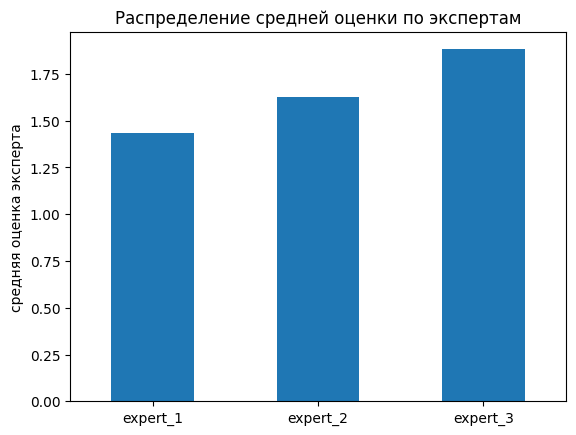

In [352]:
# средняя оценка между экспертами
temp = train_df_full[['expert_1', 'expert_2', 'expert_3']].mean()
temp.plot(kind='bar')
plt.ylabel('средняя оценка эксперта')
plt.title('Распределение средней оценки по экспертам')
plt.xticks(rotation=0);

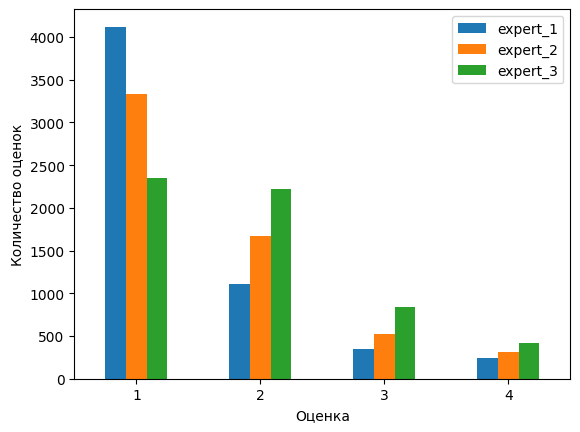

In [353]:
# посмотрим, какие оценки чаще всего выставляют эксперты
temp = train_df_full.groupby('expert_1')[['expert_1']].count()
temp['expert_2'] = train_df_full.groupby('expert_2')[['image']].count()
temp['expert_3'] = train_df_full.groupby('expert_3')[['image']].count()

temp.plot(y=['expert_1', 'expert_2', 'expert_3'], kind='bar')
plt.ylabel('Количество оценок')
plt.xlabel('Оценка')
plt.xticks(rotation=0);

Как видно из построенных барплотов, наиболее часто эксперты выставляют оценку "1". Это означает, что скорее всего большинство картинок не соответствуют описанию.

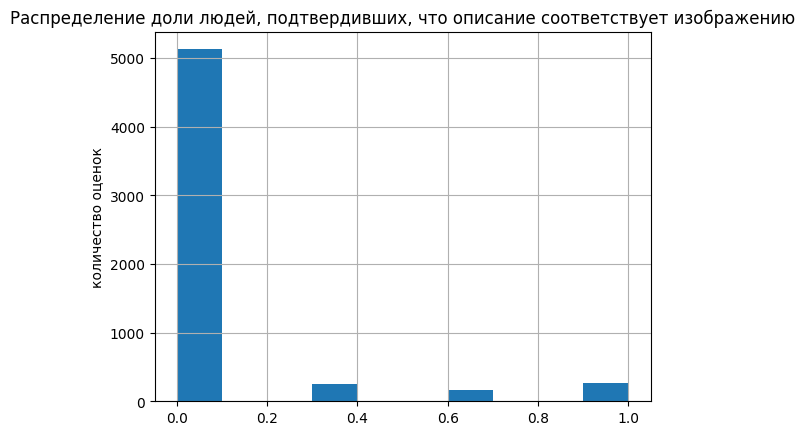

In [354]:
# распределение доли людей, подтвердивших, что описание соответствует изображению
train_df_full['share_good'].hist(bins=10)
plt.ylabel('количество оценок')
plt.title('Распределение доли людей, подтвердивших, что описание соответствует изображению');

Как видно, количество фото, где люди хотя бы раз отметили соответствие описанию менее 500

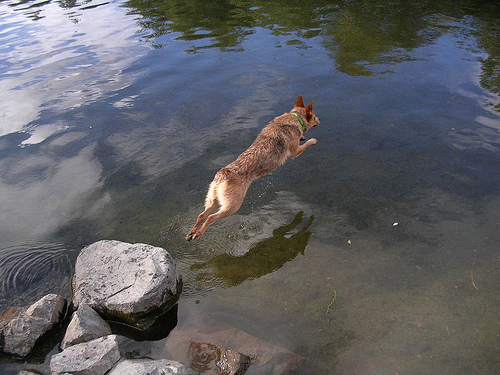

Описание: A man pulls on his sweater as a kayak lays at his feet .
Доля людей, подтвердивших, что описание соответствует изображению: 0.0
Оценки экспертов:


,3398
expert_1,1
expert_2,1
expert_3,1


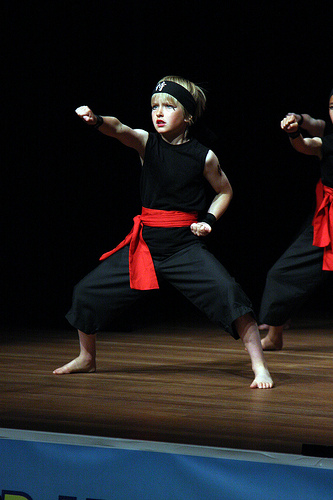

Описание: A child jumping on a tennis court .
Доля людей, подтвердивших, что описание соответствует изображению: 0.0
Оценки экспертов:


,415
expert_1,1
expert_2,1
expert_3,2


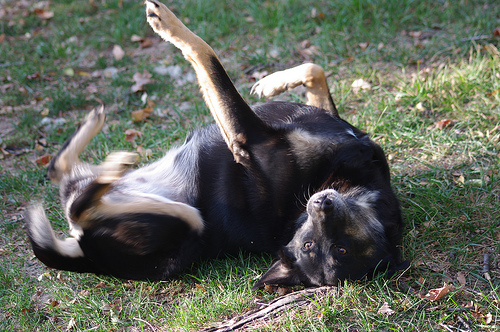

Описание: A dog rolling in the grass .
Доля людей, подтвердивших, что описание соответствует изображению: 1.0
Оценки экспертов:


,290
expert_1,4
expert_2,4
expert_3,4


In [355]:
# посмотрим на описание и оценки 3х случайных картинок
temp = train_df_full.sample(3, random_state=RANDOM_STATE)
img_temp = temp['image'].to_list()

for c, i in enumerate(img_temp):
    display(Image(filename = PATH + 'train_images/' + i))
    print('Описание:', temp.iloc[c].query_text)
    print('Доля людей, подтвердивших, что описание соответствует изображению:', temp.iloc[c].share_good)
    print('Оценки экспертов:')
    display(temp.iloc[c][['expert_1', 'expert_2', 'expert_3']])
    print()

Из трех случайных картинок две не соответствуют описанию. Третья соответствует. Большинство краудсорсинговых оценок у несоответствующих картинок отсутствуют или равны нулю.
Добавим столбец с рейтингом соответствия картинки и описания по формуле: Доля людей, подтвердивших, что описание соответствует изображению * 0.5 + средняя оценка от трех экспертов по отношению к максимально возможной оценке (12) * 0.5. Итого должна получится вероятность соответствия картинки описанию (от 0 до 1).

In [356]:
train_df_full['compliance'] = round(train_df_full['share_good']*0.5 + ((train_df_full['expert_1'] + train_df_full['expert_2'] + train_df_full['expert_3']) / 12)*0.5, 3)
train_df_full

,image,query_id,query_text,share_good,good_descr_crowd,bad_descr_crowd,expert_1,expert_2,expert_3,compliance
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,3.0,1,1,1,0.125
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,0.0,1,1,1,0.125
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,3.0,1,2,2,0.208
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,3.0,0.0,4,4,4,1.000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,0.0,1,1,1,0.125
...,...,...,...,...,...,...,...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,0.333333,1.0,2.0,2,2,3,0.458
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,0.000000,0.0,0.0,1,1,1,0.125
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0.000000,0.0,0.0,2,2,2,0.250
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0.000000,0.0,3.0,2,3,3,0.333


In [357]:
# проверим, укладываются ли значения оценки в промежуток между 0 и 1:
train_df_full.compliance.max(), train_df_full.compliance.min()

(1.0, 0.125)

In [358]:
# удалим уже ненужные колонки
train_df_full.drop(columns=['share_good', 'good_descr_crowd', 'bad_descr_crowd', 'expert_1', 'expert_2', 'expert_3'], inplace=True)
train_df_full

,image,query_id,query_text,compliance
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.125
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.125
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.208
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.125
...,...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,0.458
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,0.125
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0.250
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0.333


**Вывод**
<br>Наиболее часто эксперты выставляют оценку "1". Это означает, что скорее всего большинство картинок не соответствуют описанию. Количество фото, где люди хотя бы раз отметили соответствие описанию менее 500. Из трех случайных картинок две не соответствуют описанию. Третья соответствует. Большинство краудсорсинговых оценок у несоответствующих картинок отсутствуют или равны нулю. Был добавлен столбец с рейтингом соответствия картинки и описания по формуле: Доля людей, подтвердивших, что описание соответствует изображению * 0.5 + средняя оценка от трех экспертов по отношению к максимально возможной оценке (12) * 0.5. Итого должна получится вероятность соответствия картинки описанию (от 0 до 1).

#3 Юридическая проверка данных

In [359]:
# регулярное выражение для поиска описаний о детях младше 16
pattern = r'\b(child|children|boy|girl|baby|kid|infant|teen|(?:\bage(?:d)?\s?(?:[1-9]|1[0-6]))|(?:\b(?:[1-9]|1[0-6])\s?years? old))'

# строки, которые будут удалены
deleted_rows = train_df_full[train_df_full['query_text'].str.contains(pattern, case=False, na=False)]

# Фильтруем датафрейм: удаляем строки с запрещенным контентом
train_df_full_filtered = train_df_full[~train_df_full['query_text'].str.contains(pattern, case=False, na=False)]

<ipython-input-359-3449902934>:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  deleted_rows = train_df_full[train_df_full['query_text'].str.contains(pattern, case=False, na=False)]
<ipython-input-359-3449902934>:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  train_df_full_filtered = train_df_full[~train_df_full['query_text'].str.contains(pattern, case=False, na=False)]


In [360]:
train_df_full_filtered

,image,query_id,query_text,compliance
22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.167
23,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.208
24,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.250
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.208
26,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.167
...,...,...,...,...
5816,799486353_f665d7b0f0.jpg,2170222061_e8bce4a32d.jpg#2,"A small animal leaps behind a larger animal , ...",0.125
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,0.125
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0.250
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0.333


In [361]:
deleted_rows

,image,query_id,query_text,compliance
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.125
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.125
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.208
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.125
...,...,...,...,...
5802,430173345_86388d8822.jpg,523985664_c866af4850.jpg#2,A girl wearing a swimsuit top wears a sign to ...,0.125
5803,444481722_690d0cadcf.jpg,1352410176_af6b139734.jpg#2,A young girl balances on wooden pylons at the ...,0.125
5804,488408004_a1e26d4886.jpg,1352410176_af6b139734.jpg#2,A young girl balances on wooden pylons at the ...,0.125
5814,751109943_2a7f8e117f.jpg,2475162978_2c51048dca.jpg#2,a woman holding a small ball chasing after a s...,0.167


**Вывод**
<br> Запрещенные запросы были удалены из тренировочной выборки. Осталось 4291 строк для обучения и валидации.

# 4 Векторизация изображений

Загрузим картинки

In [362]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df_full_filtered,
        directory= PATH + 'train_images/',
        x_col='image',
        y_col='compliance',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=15)

features, target = next(train_gen_flow)

Found 4291 validated image filenames.


In [363]:
# создадим свертночную нейросеть. Используем для этого ResNet50, полносвязный слой вклчать не будем
def create_model():

    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

In [365]:
# извлечем признаки из изображения:
def image_vec(model, train_data):
    preds = model.predict(train_data)
    return preds

image_embedings = image_vec(create_model(), train_gen_flow)
image_embedings.shape

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


269/269 ━━━━━━━━━━━━━━━━━━━━ 821s 3s/step


(4291, 2048)

# 5 Векторизация текстов

In [369]:
def text_vec(dataframe, column):
    # функция создания текстовых эмбедингов через bert

    # инициализация токенизатора bert
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # токенизация текстовых описаний
    tokenized = dataframe[column].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

    # определяем максимальную длину токенов
    max_len = max(len(i) for i in tokenized.values)

    # применяем padding к токенам
    padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

    # создаём маску
    attention_mask = np.where(padded != 0, 1, 0)

    # загружаем предобученную модель bert и перемещаем её на gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertModel.from_pretrained('bert-base-uncased').to(device)

    # вычисляем эмбеддинги батчами
    batch_size = 100
    embeddings = []
    padded = torch.LongTensor(padded).to(device)
    attention_mask = torch.LongTensor(attention_mask).to(device)

    for i in notebook.tqdm(range((padded.shape[0] + batch_size - 1) // batch_size), desc="Генерация эмбеддингов"):
        # формируем батч
        batch = padded[batch_size * i: batch_size * (i + 1)]
        attention_mask_batch = attention_mask[batch_size * i: batch_size * (i + 1)]

        # вычисляем эмбеддинги
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        # извлекаем эмбеддинги
        embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu().numpy())

    # объединяем эмбеддинги в один массив
    global text_embedings
    text_embedings = np.concatenate(embeddings, axis=0)

    return text_embedings

In [370]:
text_vec(train_df_full_filtered, 'query_text')

Генерация эмбеддингов:   0%|          | 0/43 [00:00<?, ?it/s]

array([[ 0.22594534, -0.14776999, -0.41042703, ..., -0.31920707,
         0.4300092 ,  0.24305446],
       [ 0.22594534, -0.14776999, -0.41042703, ..., -0.31920707,
         0.4300092 ,  0.24305446],
       [ 0.22594534, -0.14776999, -0.41042703, ..., -0.31920707,
         0.4300092 ,  0.24305446],
       ...,
       [-0.0815836 ,  0.05398389, -0.82227427, ..., -0.20570725,
         0.3630543 ,  0.26102594],
       [-0.52356017, -0.2747075 , -0.8157735 , ..., -0.14736871,
         0.11889751,  0.06756736],
       [-0.06578778,  0.02755437, -0.31210837, ..., -0.312639  ,
         0.15028909,  0.29312912]], dtype=float32)

# 6 Объединение векторов

In [371]:
features = np.concatenate((image_embedings, text_embedings), axis=1)
features.shape

(4291, 2816)

In [372]:
target = np.array(train_df_full_filtered['compliance'])
target.shape

(4291,)

In [373]:
features

array([[ 0.        ,  0.        ,  0.00188098, ..., -0.31920707,
         0.4300092 ,  0.24305446],
       [ 0.        ,  0.        ,  0.        , ..., -0.31920707,
         0.4300092 ,  0.24305446],
       [ 0.        ,  0.        ,  0.        , ..., -0.31920707,
         0.4300092 ,  0.24305446],
       ...,
       [ 0.        ,  0.        ,  0.00240362, ..., -0.20570725,
         0.3630543 ,  0.26102594],
       [ 0.        ,  0.        ,  0.        , ..., -0.14736871,
         0.11889751,  0.06756736],
       [ 0.        ,  0.        ,  0.0348649 , ..., -0.312639  ,
         0.15028909,  0.29312912]], dtype=float32)

In [374]:
# проверка на наличие пропусков
contains_nan = np.isnan(features).any()
print(f"Содержатся ли пропуски в features: {contains_nan}")

Содержатся ли пропуски в features: False


**Вывод**
<br>Описания и картинки были переведены в вектора и объеденены в один массив.

#7 Обучение модели предсказания соответствия

Разобъем данные на тренировочную и валидационную выборки в соотношении 70/30:

In [375]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=15)

train_indices, test_indices = next(gss.split(X=features, y=target, groups=train_df_full_filtered['image']))

X_train, X_val = features[train_indices], features[test_indices]
y_train, y_val = target[train_indices], target[test_indices]

В качестве метрики качества выберем среднеквадратичную ошибку (RMSE). Она измеряет среднюю величину различий между прогнозируемыми значениями и фактическими значениями.
<br>Посмотрим, как с задачей справится линейная регрессия:

In [376]:
model_lr = LinearRegression()

In [377]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [378]:
predictions = model_lr.predict(X_val)
print('RMSE линейной регрессии на валидационной выборке:', np.sqrt(mean_squared_error(y_val, predictions)))

RMSE линейной регрессии на валидационной выборке: 0.28792833884766583


Теперь посмотрим на нейросеть(НС):

In [379]:
model_ns = Sequential()
model_ns.add(Dense(512, activation='relu', input_shape=(2816,)))
model_ns.add(Dropout(0.2))
model_ns.add(Dense(128, activation='relu'))
model_ns.add(BatchNormalization())
model_ns.add(Dense(64, activation='relu'))
model_ns.add(Flatten())
model_ns.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.0001)

model_ns.compile(loss='mean_squared_error',
                optimizer = optimizer,
                metrics=[RootMeanSquaredError()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [380]:
model_ns.fit(X_train,
             y_train,
             epochs=5,
             batch_size=32,
             validation_data=(X_val, y_val),
             verbose=2)

Epoch 1/5
94/94 - 4s - 48ms/step - loss: 0.5490 - root_mean_squared_error: 0.7410 - val_loss: 0.0802 - val_root_mean_squared_error: 0.2832
Epoch 2/5
94/94 - 3s - 31ms/step - loss: 0.2780 - root_mean_squared_error: 0.5273 - val_loss: 0.0687 - val_root_mean_squared_error: 0.2621
Epoch 3/5
94/94 - 4s - 48ms/step - loss: 0.2022 - root_mean_squared_error: 0.4497 - val_loss: 0.1072 - val_root_mean_squared_error: 0.3274
Epoch 4/5
94/94 - 3s - 27ms/step - loss: 0.1723 - root_mean_squared_error: 0.4151 - val_loss: 0.0839 - val_root_mean_squared_error: 0.2897
Epoch 5/5
94/94 - 3s - 27ms/step - loss: 0.1555 - root_mean_squared_error: 0.3944 - val_loss: 0.0692 - val_root_mean_squared_error: 0.2630


**Вывод**
<br>RMSE линейной регрессии - 0,288, а НС - менее 0,25 (хотя результат у НС переменный). Для дальнейшей работы примем обученную нейросеть.

# 8 Тестирование модели

In [382]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=test_images,
        directory= PATH + 'test_images/',
        x_col='image',
        y_col='compliance',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=15)

Found 100 validated image filenames.


In [404]:
# векторизация картинок
image_embedings = image_vec(create_model(), test_gen_flow)
image_embedings.shape

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step


(100, 2048)

In [396]:
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en')
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

In [ ]:
WORD_TO_BLOCK = ['child', 'boy', 'girl', 'baby', 'teen', 'teenager', 'kid', 'infant', 'youngster', 'kids', 'children', 'boys', 'girls', 'babies', 'teens', 'teenagers']
l = WordNetLemmatizer()

In [415]:
def txt_vec(text):

    test_embeddings = []
    tokenized = preprocessor(text)
    batch_size=5

    for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):
        tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
        token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
        mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]
        batch = {'token_ids' : tokens,
                'segment_ids' : token_types,
                'padding_mask' : mask}
        batch_embeddings = bert.predict(batch, verbose=0)
        test_embeddings.append(batch_embeddings['pooled_output'])

    text_embeddings_test = np.concatenate(test_embeddings)
    return text_embeddings_test

In [416]:
def lemmatize_text(phrase):

    phrase = re.sub('[^a-zA-Z]', ' ', phrase).lower()
    phrase = nltk.word_tokenize(phrase, language = 'english')
    phrase = [l.lemmatize(word) for word in phrase]
    return phrase

In [425]:
def inference(text):

    bin_array = [i for i in lemmatize_text(text) if i in WORD_TO_BLOCK]
    if bin_array:
        print('Описание:', text)
        print('--This image is unavailable in your country in compliance with local laws--')
        print()
    else:
        print('Описание:', text)
        text_embed = txt_vec(text = [text])
        feature = np.concatenate((image_embedings, np.resize(text_embed, (image_embedings.shape[0],768))), axis=1) # Тк входные тензоры 1 и 500, нам необходимо изменить размер массива
        predictions = model_ns.predict(feature)

        data = pd.concat((test_queries, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='predictions')), axis=1)
        top = list(data.sort_values(by='predictions', ascending=False)['image'].head(5))
        top_score = list(data.sort_values(by='predictions', ascending=False)['predictions'].head(5))
        print('Картинки с наивысшим complience:', top)
        print('complience:', top_score)
        display(Image(filename = PATH + 'test_images/' + top[0]))
        print()

Описание: A woman and two children pose for a picture under some rocks .
--This image is unavailable in your country in compliance with local laws--

Описание: Cyclists are leaping into the air whilst being watched by spectators .


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Картинки с наивысшим complience: ['1232148178_4f45cc3284.jpg', '2399219552_bbba0a9a59.jpg', '1580671272_3e99d94305.jpg', '1745110280_0cbff5e273.jpg', '1319634306_816f21677f.jpg']
complience: [0.2962549328804016, 0.292544960975647, 0.2870360016822815, 0.2774351239204407, 0.27691274881362915]


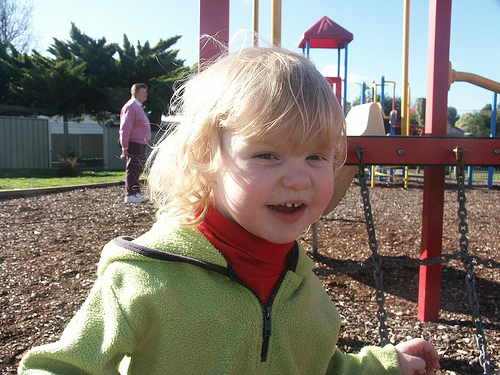


Описание: Two boys and a white dog stand in a park .
--This image is unavailable in your country in compliance with local laws--

Описание: A young boy throwing a rock into a pond in front of a large building .
--This image is unavailable in your country in compliance with local laws--

Описание: Three little boys standing next to and on a fence .
--This image is unavailable in your country in compliance with local laws--

Описание: A dog is wearing jeans and a blue and yellow shirt with a black vehicle in the background .


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Картинки с наивысшим complience: ['2399219552_bbba0a9a59.jpg', '1232148178_4f45cc3284.jpg', '1580671272_3e99d94305.jpg', '1745110280_0cbff5e273.jpg', '2107838729_a527e434bd.jpg']
complience: [0.1999238133430481, 0.18222779035568237, 0.16542655229568481, 0.16242605447769165, 0.1577550172805786]


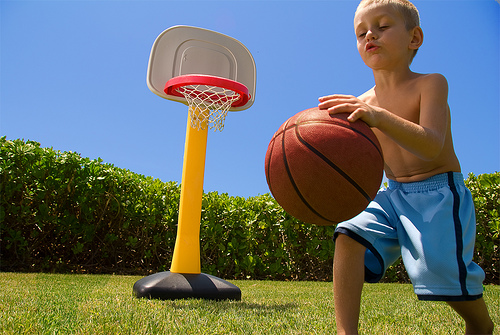


Описание: many people walk through the store .


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Картинки с наивысшим complience: ['1232148178_4f45cc3284.jpg', '2399219552_bbba0a9a59.jpg', '1580671272_3e99d94305.jpg', '186346360_541047336f.jpg', '2346402952_e47d0065b6.jpg']
complience: [0.37090784311294556, 0.3652493953704834, 0.3618693947792053, 0.3576052784919739, 0.34394341707229614]


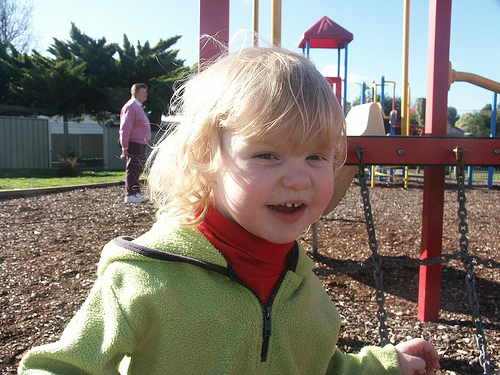


Описание: The light colored dog is running through a field .


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Картинки с наивысшим complience: ['2399219552_bbba0a9a59.jpg', '1745110280_0cbff5e273.jpg', '1232148178_4f45cc3284.jpg', '1580671272_3e99d94305.jpg', '2346402952_e47d0065b6.jpg']
complience: [0.2132110595703125, 0.19548475742340088, 0.1919814944267273, 0.17081719636917114, 0.16779249906539917]


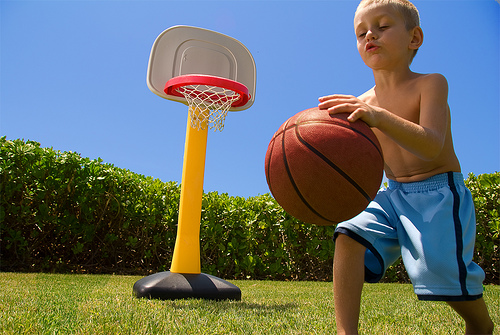


Описание: A man is jumping off a rock into a pool of water while three others watch .


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Картинки с наивысшим complience: ['1232148178_4f45cc3284.jpg', '2399219552_bbba0a9a59.jpg', '1580671272_3e99d94305.jpg', '186346360_541047336f.jpg', '2346402952_e47d0065b6.jpg']
complience: [0.26827722787857056, 0.26534026861190796, 0.25523173809051514, 0.2509821653366089, 0.24287718534469604]


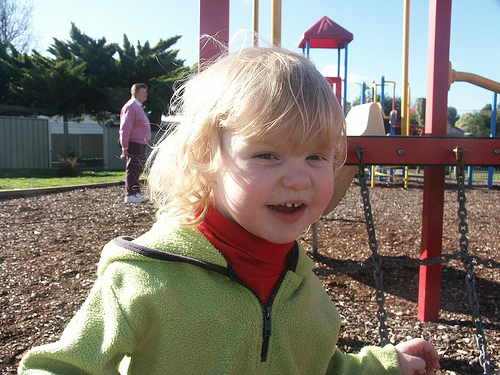


Описание: two people sit on a park bench .


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Картинки с наивысшим complience: ['2399219552_bbba0a9a59.jpg', '1232148178_4f45cc3284.jpg', '186346360_541047336f.jpg', '1580671272_3e99d94305.jpg', '2201192417_d934730fea.jpg']
complience: [0.3142687678337097, 0.3095064163208008, 0.3079240322113037, 0.3036789894104004, 0.2946016192436218]


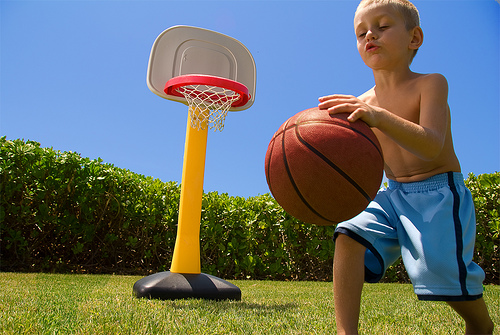

In [426]:
test_phrases = list(test_queries['query_text'].sample(10))
for phrase in test_phrases:
    inference(phrase)

**Вывод**
<br>В результате проверки посторенной модели на тестовых данных результат получился неудовлетворительный. Ни одно выдаваемое фото не подходит под описание. Более того чаще метрика завышена для одной, двух картинок. Применение модели BERT для векторизации описаний также не помогает решить проблему.